In [8]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import ast
import logging
from msig import Motif, NullModel
from config import RESULTS_MOTIF_DIR, RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, VARIABLES, NORMALIZE_FLAGS, STUMPY_EXCL_ZONE_DENOM, TOP_K_MP, INCLUDE, NORMALIZE, SUBSQUENCES_LENGTHS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")


if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

Results will be saved in: /home/mgsilva/motifpred/results/household
Images will be saved in: /home/mgsilva/motifpred/images/household
Data will be accessed from: /home/mgsilva/motifpred/data/household


In [9]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[["Features","m", "Indices"]]
motifs_sizes = mp_stats_table[["m"]].values.flatten().astype(int)
motifs_indexes = mp_stats_table[["Indices"]].values
motifs_indexes = [ast.literal_eval(item[0]) for item in motifs_indexes]


In [10]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.5035, 0.9978, 0.3884],
        [0.6929, 0.1703, 0.1384],
        [0.4759, 0.7481, 0.0361],
        [0.5062, 0.8469, 0.2588],
        [0.2707, 0.4115, 0.6839]])


In [11]:
#load data as 
df_data = pd.read_csv(DATA_DIR / 'data.csv', index_col=0).astype(float)

labels = pd.read_csv(DATA_DIR / 'labels.csv', index_col=0).astype(float)
data = df_data.values.T
data 

array([[1.3000e+00, 1.2820e+00, 1.3020e+00, ..., 6.2000e-01, 6.2000e-01,
        6.1800e-01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 8.0000e-02, 8.0000e-02,
        8.0000e-02],
       [2.4304e+02, 2.4330e+02, 2.4340e+02, ..., 2.4520e+02, 2.4515e+02,
        2.4490e+02],
       [5.4000e+00, 5.2000e+00, 5.2000e+00, ..., 2.6000e+00, 2.6000e+00,
        2.6000e+00]])

TRAIN: [    0     1     2 ... 12438 12439 12440] TEST: [12441 12442 12443 ... 15549 15550 15551]
TRAIN: [15552 15553 15554 ... 27990 27991 27992] TEST: [27993 27994 27995 ... 31101 31102 31103]
TRAIN: [31104 31105 31106 ... 43542 43543 43544] TEST: [43545 43546 43547 ... 46653 46654 46655]
TRAIN: [46656 46657 46658 ... 59094 59095 59096] TEST: [59097 59098 59099 ... 62205 62206 62207]
TRAIN: [62208 62209 62210 ... 74646 74647 74648] TEST: [74649 74650 74651 ... 77757 77758 77759]


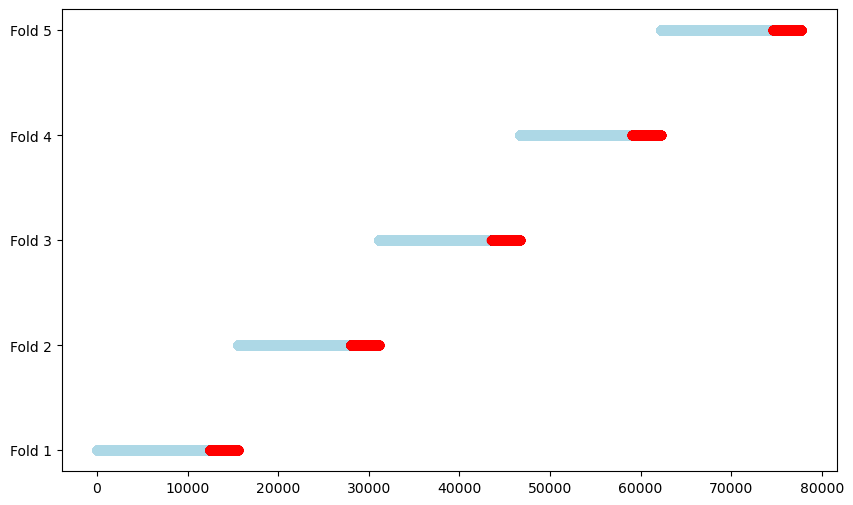

In [12]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [13]:
from utils.utils import create_multi_motif_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, X_mask, y = create_multi_motif_dataset(data, lookback_period, step, forecast_period, motifs_indexes, motifs_sizes)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([51427, 100, 4])
X_mask shape: torch.Size([51427, 100])
X_indices shape: torch.Size([51427, 4, 1])
y shape: torch.Size([51427, 1])


[I 2025-01-21 15:09:57,704] A new study created in memory with name: no-name-68bb8c92-0605-44d8-8921-c8efef195ab2


Training completed all epochs. Best epoch was 198
Training completed all epochs. Best epoch was 198
Early stopping at epoch 151, with best epoch being 140
Training completed all epochs. Best epoch was 198


[I 2025-01-21 15:21:49,513] Trial 0 finished with value: 201.37909545898438 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 32}. Best is trial 0 with value: 201.37909545898438.


Training completed all epochs. Best epoch was 198
Early stopping at epoch 175, with best epoch being 164
Early stopping at epoch 154, with best epoch being 143
Early stopping at epoch 111, with best epoch being 99
Early stopping at epoch 161, with best epoch being 150


[I 2025-01-21 15:27:54,054] Trial 1 finished with value: 201.36451110839843 and parameters: {'learning_rate': 1.793578709982463e-05, 'num_layers': 1, 'batch_size': 128, 'hidden_size_layer_0': 256}. Best is trial 1 with value: 201.36451110839843.


Early stopping at epoch 154, with best epoch being 143
Early stopping at epoch 111, with best epoch being 95
Early stopping at epoch 113, with best epoch being 97
Early stopping at epoch 114, with best epoch being 58
Early stopping at epoch 113, with best epoch being 95


[I 2025-01-21 15:32:22,028] Trial 2 finished with value: 201.3603973388672 and parameters: {'learning_rate': 7.653371871786874e-05, 'num_layers': 1, 'batch_size': 64, 'hidden_size_layer_0': 64}. Best is trial 2 with value: 201.3603973388672.


Early stopping at epoch 122, with best epoch being 90
Best hyperparameters: {'learning_rate': 7.653371871786874e-05, 'num_layers': 1, 'batch_size': 64, 'hidden_size_layer_0': 64}
Number of finished trials:  3
Best trial: 2
Best hyperparameters: {'learning_rate': 7.653371871786874e-05, 'num_layers': 1, 'batch_size': 64, 'hidden_size_layer_0': 64}
Validation Losses: [203.237, 202.991, 203.031, 205.117, 192.426]
Mean validation loss: 201.36
Test Losses: [201.175, 201.032, 202.347, 201.0, 199.831]
Mean test loss: 201.077
Mean test MAE: 12.224 std: 0.041
Mean test RMSE: 14.18 std: 0.028


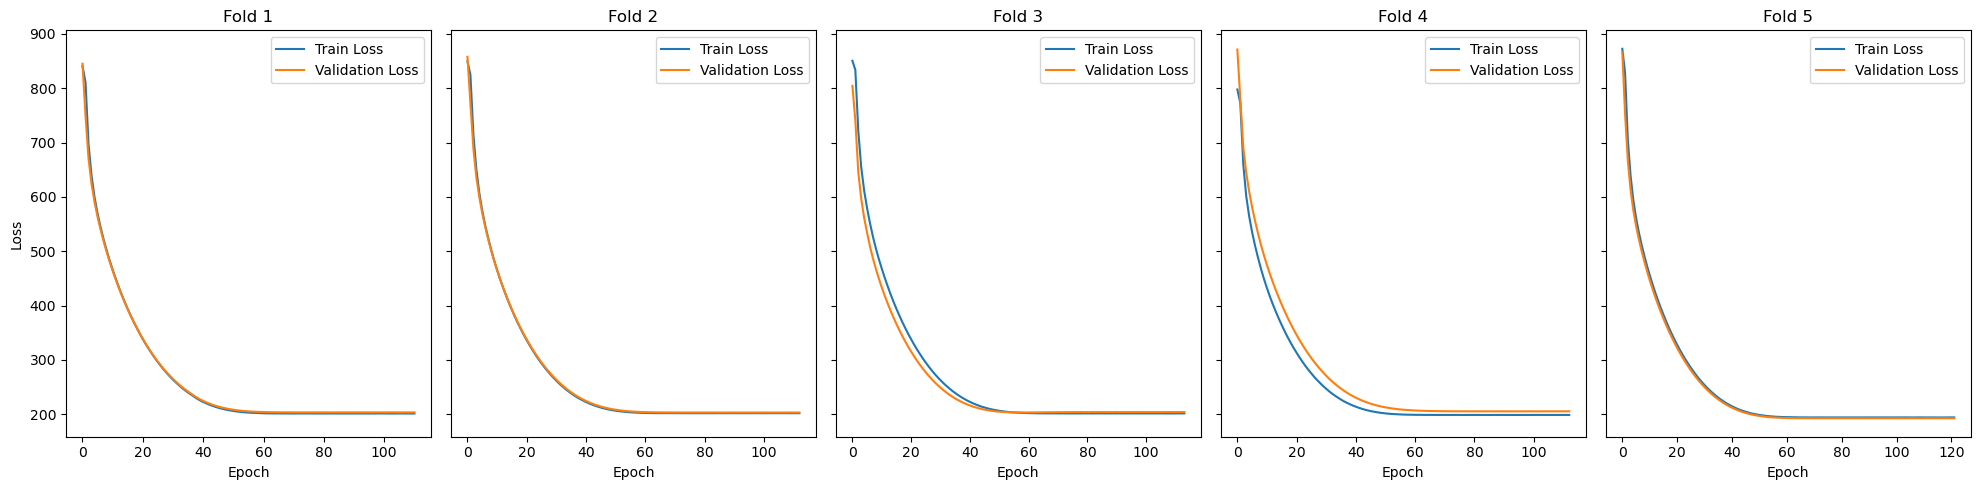

In [14]:
from models.lstm_pytorch import LSTM
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 3
num_epochs = 200
model_type = "LSTM"
model_name = "LSTMSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series}
run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
